# COGS 108 Final Project: Optimization of Police Car Placement in San Diego
## Emma Roth
## Eric	Mauritzen
## Keven Nguyen
## Taralyn Mcnabb

## Introduction, Background, Overview

### Project Overview
- Introduction, background, overview
    - Introduce the background and goals of the project
- Data Loading and Preprocessing
    - Load raw datasets
    - Perform basic cleaning and filtering
- Data Visualization—what does our crime data look like?
    - Exploratory data analysis 
    - How is our data distributed temporally and spatially
- Patrol Car Optimization
    - Establish baseline distribution
    - Improve the patrol car distribution methods with Simulated Annealing
- Conclusion and Discussion
    - Review of Results
    - Implications of Results
    - To what extent did we answer questions
    - Further work
---

Police and fire department response times can often mean the difference between life and death. However, when you live in a highly populated county like San Diego, response times are affected by the heavy local traffic. An article by the La Jolla Light discusses how in 2011, increased traffic and reduced police force caused by budget cuts caused the average response time to increase. When comparing La Jolla to Solana Beach, a 5-minute difference in average response time was reported. Our project aims to use publically available San Diego police dispatch data to suggest an optimal placement of police cars across the SDPD jurisdiction. In this model, we define “optimal” as minimizing linear distance between a placed police car and an area with high crime probability. 

#### Hypothesis
In this exploration, we hypothesize firstly, that crime is not evenly distributed throughout the city of San Diego, and secondly, that the distribution of crime will change throughout the day. Furthermore, we predict that this uneven distribution of crime can be exploited to develop a car distribution algorithm that distributes cars more effectively than naive solutions such as uniform or Gaussian car placement.

#### A Note on Notebook Layout
We used Bokeh for plotting.  We are attracted to Bokeh's beautiful plots and the ease with which we could plot geographical data.  This came at the cost of plots not appearing on committed github notebooks.  In order to view the figures, we saved them separately, in an HTML file because Bokeh requires this, and took a screenshot of this page.  We then loaded the saved `.png` file into the notebook using the IPython display library.



## Data Loading and Preprocessing
We began by importing relevant packages. The packages we used were pretty standard. Bokeh is an interactive Python library for data visualization and works well with large datasets. Seaborn is also a visualization library, and it is built on top of matplotlib and tightly integrated with PyData stack. Pyproj is used to convert latitude/longitude coordinates to x, y coordinates. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image, display
import pandas as pd
import xml.etree.ElementTree as ET
import seaborn as sns
import address_utils
import numpy as np
import matplotlib.pyplot as plt
import math
from bokeh.plotting import figure, output_notebook, show, save
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
import datetime
from bokeh.tile_providers import STAMEN_TERRAIN
from pyproj import Proj, transform
output_notebook()

%matplotlib inline

Loading BokehJS ...

### Address Utilities

The dictionaries below are used to expand the appreviations of street types in the police dataset to the street types in the OSM data.

In [2]:
strdirExpand = {'E':'East', 'S':'South', 'N':'North', 'W':'West'}
strTypeExpand = {'ST':'Street', 'AV':'Avenue', 'DR':'Drive', \
                 'RD':'Road', 'BL':'Boulevard', 'WY':'Way', 'CT':'Court', \
                 'PL':'Place', 'LN':'Lane', 'PY':'Parkway', 'HY':'Highway'}

strTypeKeys = strTypeExpand.keys()
strDirKeys = strdirExpand.keys()
                     


Open Street Maps is an open data source to which a community of mappers contributes information about roads, trails, businesses, etc. OSM allows you to download XML files with all available city data within a user-determined lat/long range. OSM data is made of “elements” , which are essentially just data points. Elements have tags, which are a key/value pair descriptors. Examples include things like “amenity=fast_food”, “brand=McDonald’s”, “addr:street=Genesee”, “highway=residential”, plus many, many, more. We downloaded the OSM San Diego data and stored it in a file called “map”.
Since map is an XML file, we parsed it into an Element Tree for easy manipulation. We then counted how many points we had in the dataset: slightly more than 3 million. 
For every node in the tree that contained information about city, postcode, house number, and street, we wrote this information to a table and included the lat/lon values. Entries without this essential information were ignored.  

In [3]:
# OSM
tree = ET.parse('data/map')
root = tree.getroot()

n = [child for child in root.iter('node')]

with open('OSM_TABLE.tsv', 'wb') as f:
    for anode in n:
        lat = anode.attrib['lat']
        lon = anode.attrib['lon']
        d = dict()
        for child in anode.getchildren():
            d[child.attrib['k']] = [child.attrib['v']][0]
        if 'addr:city' in d.keys() and 'addr:postcode'  in d.keys() and 'addr:housenumber'  in d.keys() and 'addr:street'  in d.keys():
            ostr = '%f\t%f\t%s\t%s\t%s\t%s\n' %( float(lat), float(lon), d['addr:city'], d['addr:street'], str(d['addr:housenumber']), d['addr:postcode'])
            f.write(ostr.encode('utf8'))
            
del tree
del root
del n
del lat
del lon
del d
del ostr


Next, we did some basic data wrangling, making sure street numbers were numeric, that names had uniform capitalization, and sorting values for search optimization. We also loaded all of the CSV police calls for service files downloaded directly from data.sandiego.gov. These files contain the type of police dispatch, a date and timestamp, an address, the priority assigned to the situation by the dispatcher, and the “beat” (neighborhood) the event happened in.

The calls in the dataset are not all crimes. For example, code 1042 means “end of shift”, and 10-97 means “arrive on scene”. Given the dataset “Police Calls Disposition Codes Description”, we curated our own dataset by labeling each code as a crime or non-crime and further dividing crimes into violent and nonviolent crime. We then merged this dataset with the set of calls for service, and dropped any entries in the “calls” table that was not a crime entry. The last bit of code in this section is a little more data wrangling to ensure uniformity throughout our data. 

In [4]:
%%time
# Import data | Expand street_type string
df_locations = pd.read_table('data/OSM_TABLE.tsv', names=['lat', 'lon', 'city', 'street', 'house_num', 'post_code'], low_memory=False)

# Convert the street numbers to numeric values, not strings
df_locations['house_num'] = pd.to_numeric(df_locations['house_num'], errors='coerce')

# Convert the street names to uppercase to ease matching process
df_locations['street'] = df_locations['street'].str.upper()

# Sort the values to optimize searching
df_locations.sort_values(by='street', inplace=True)

#load all calls into single dataframe
df_calls2017 = pd.read_csv('data/Calls For Service/pd_calls_for_service_2017_datasd.csv', low_memory=False)
df_calls2016 = pd.read_csv('data/Calls For Service/pd_calls_for_service_2016_datasd.csv', low_memory=False)
df_calls2015 = pd.read_csv('data/Calls For Service/pd_calls_for_service_2015_datasd.csv', low_memory=False)
df_calls = pd.concat([df_calls2015, df_calls2016, df_calls2017])

#load categorized codes
codes = pd.read_csv('data/CategtorizedCodes.csv')

# Merge the two tables on the basis of 'call_type'
df_calls = df_calls.merge(codes, on='call_type')
df_calls = df_calls.loc[df_calls['Keep'] == 1]


# Expand streettype abbreviations to match OSM format
df_calls['streettype'] = [strTypeExpand[x] if x in strTypeKeys else None for x in df_calls['streettype'].values ]
orig_col = df_calls.columns

Wall time: 5.99 s


### Geocoding Step

The purpose of this step is to get the reported addresses of these crimes into plottable format. The way to do this is to match the street addresses to latitude and longitude coordinates, and then from there, convert lat/lon into x/y coordinates. The below block of code gets rid of duplicate addresses in the “calls” data and counts the number of addresses in the dataset. It also sets up columns to fill with the matching lat/lon coordinates.


In [5]:
# The addresses dataframe has one entry per UNIQUE address in the police dataset.
# This allows us to geocoede once per unique address and not once per address.
pd.options.mode.chained_assignment = None
df_addresses = df_calls[['stno', 'stdir1', 'street', 'streettype']]
df_addresses = df_addresses.drop_duplicates()
df_addresses.loc[:,'lat'] = 0.0
df_addresses.loc[:,'lon'] = 0.0
df_addresses.loc[:,'nmatches'] = 0.0
print('There are %d unique addresses that need to be matched' % len(df_addresses))
df_addresses.head()

There are 34781 unique addresses that need to be matched


stno stdir1     street streettype  lat  lon  nmatches
6600  1400    NaN  HORNBLEND     Street  0.0  0.0       0.0
6601     0    NaN   EL CAJON  Boulevard  0.0  0.0       0.0
6602     0    NaN     MILTON     Street  0.0  0.0       0.0
6603  3100    NaN    MISSION  Boulevard  0.0  0.0       0.0
6604     0    NaN       54TH     Street  0.0  0.0       0.0

Here, we attempt to match the addresses provided in the police calls data with lat/lon values. Any addresses that had no compatible matches in OSM were dropped. The 58.21% refers to UNIQUE addresses that do not have latitude/longitude matches. For example, if our dataset was 12 Smith Street (1 crime) and 13 John Street (200 crimes), and 12 Smith Street did not have a lat/lon match, this portion of code would return that 50% of our dataset had lat/lon matches. 

In [6]:
%%time
# We iterate over every address
    # Select all OSM entries with matching street name
    # Select from these the OSM entries with compatible street numbers
    # Get the centroid of the lattitude Longitude coordinates
for i, row in df_addresses.iterrows():

    
    # Search for a match in the street name, direction, and type
    street_string = address_utils.CompileAddressString(None, row['stdir1'], row['street'], row['streettype']).upper()
    top = df_locations['street'].searchsorted(street_string, 'left')
    bot = df_locations['street'].searchsorted(street_string, 'right')
    
    # Create a dataframe of possible matches
    df_matchingStreets = df_locations[int(top):int(bot)]
    
    # Now filter by compatible house number
    house_num = int(row['stno'])
    if house_num < 100:
        house_range = 10
    else:
        house_range = 100
    
    df_matchingStreets = df_matchingStreets.loc[((house_num-house_range) <= df_matchingStreets['house_num']) & (df_matchingStreets['house_num'] <= (house_num+house_range)) ]
    df_addresses.loc[i, 'nmatches'] = len(df_matchingStreets)
    df_addresses.loc[i, 'lat'] = df_matchingStreets.mean()['lat']
    df_addresses.loc[i, 'lon'] = df_matchingStreets.mean()['lon']

    

pct_match = (len(df_addresses) - df_addresses['nmatches'].value_counts()[0])/float(len(df_addresses)) * 100
print('There are %d unique addresses in the police database' % len(df_addresses))
print('%d addresses have no compatible matches in the openstreetmaps database' % df_addresses['nmatches'].value_counts()[0])
print('%.2f%% of the addresses have lat/lon matches.  This DOES NOT mean that %.2f%% of the crime entries have matches' % (pct_match,pct_match))

There are 34781 unique addresses in the police database
14535 addresses have no compatible matches in the openstreetmaps database
58.21% of the addresses have lat/lon matches.  This DOES NOT mean that 58.21% of the crime entries have matches
Wall time: 1min 42s


We merged call data with latitude and longitude coordinates, and dropped any entries that were missing essential information (NA value in important column). We then calculated the number of points remaining after the above wrangling. 

In [7]:
# Create lat and lon columns for the police data
df_calls = df_calls[orig_col]
df_calls = df_calls.merge(df_addresses, on=['stno', 'stdir1', 'street', 'streettype'])

df_calls['x'],df_calls['y'] = address_utils.toMercator(list(df_calls['lon']), list(df_calls['lat']))
df_interest = df_calls[['incident_num','beat','date_time', 'x', 'y', 'Violent', 'Theft']]

df_interest.dropna(axis=0, how='any', subset=['x'], inplace=True)

print('After removing non-crime and entries that cannot be geocoded, %d crime points remain.\n' % len(df_interest))

After removing non-crime and entries that cannot be geocoded, 453756 crime points remain.



Below, we sort the data into daytime crime and nighttime crime. We defined “daytime” to mean hours when the sun is generally up (6am to 6pm), and “nighttime” to be the hours that the sun is generally down (after 6pm to before 6am the next day). We did this to examine whether crime concentration changes depending on the time of day. If there is a drastic change between day/night, the optimal car placement may need to be different during the day and night. 


In [8]:
# Given the date time string in the police data format, determine if it takes place at day or night time. 
def date_conversion(x):
    time = x[-8:]
    time = datetime.datetime.strptime(time, "%H:%M:%S")
    AM_6 = datetime.datetime.strptime('06:00:00', "%H:%M:%S")
    PM_6 = datetime.datetime.strptime('18:00:00', "%H:%M:%S")
    #Label the calls
    if time >= AM_6 and time < PM_6:
        return 'DAY'
    else:
        return 'NIGHT'


Here, we assigned crimes we categorized as “violent” an arbitrarily higher weight (4) than crimes we categorized as “nonviolent”. In the next block, we create data frames for day, night, and total crime. 

In [9]:
df_interest['weight'] = [1 if x == 0 else 4 for x in df_interest['Violent']]
df_interest['datetime'] = df_interest.apply(lambda row: date_conversion(row['date_time']), axis=1)

In [10]:
df_day = df_interest.loc[df_interest['datetime'] == 'DAY']
df_night = df_interest.loc[df_interest['datetime'] == 'NIGHT']
df_total = df_interest.copy()

## Data Exploration and Visualization

"calls_xy" will be the dataset containing all of the calls made in the last ~2.5 years. Our variables of interest for this exploratory analysis will be the `beat` and `date_time` variables. `beat` is essentially a nickname for divisions or neighborhoods in San Diego. This will be used in proxy of a call's address to make our analysis simple.

In [118]:
df = df_total.copy()
beat_dict = pd.read_csv('data/Beats/pd_beat_neighborhoods_datasd.csv')

Before we can run our analyses, we need to clean up the beat column. Due to data entry errors from the data source and some missing beat values for calls this is a necessary step to be accurate.

In [119]:
%%time
# Drop badly coded beats
df = df.dropna(axis=0,how='any', subset=['beat'])
df = df.drop(df[(df.beat == 0) | (df.beat == 0.0) | (df.beat == '000') | (df.beat == 'nan') | (df.beat == 'PC') | (df.beat == 'R') | (df.beat == 'X') | (df.beat == '5.0')].index)

# Some calls had beats that were coded in as a string and others as floats.
# This turns the floats into strings
def beat_stripper(b):
    if type(b) == float:
        b = str(b)
        b = b[:3]
        return b
    elif len(b) > 3:
        b = b[:3]
        return b
    else:
        return b

# Some strings were coded in a float format, ie: '66.0',
# so this fixes that and changes all the strings into integers
def beat_wrangler(w):
    beat = w
    if beat == '99.':
        return 0
    elif beat == '97':
        return 0
    elif beat == 'nan':
        return 0
    elif beat[-2:] == '.0':
        return 0
    else:
        return int(beat)

    
df['beat'] = df.apply(lambda row: beat_stripper(row['beat']), axis=1)
df['beat'] = df.apply(lambda row: beat_wrangler(row['beat']), axis=1)

# Although the format is correct now there are some beats that do not exist.
# They must have been entry errors, so these need to be removed too.
keepBeats = beat_dict['Beat']
df = df[df['beat'].isin(keepBeats)]

Wall time: 20.7 s


Let's look at the distribution of police calls to specific beats in San Diego.
To do that, we must group all the beats and their respective counts.

We can see that after sorting the counts by descending order that the first three beats stick out the most - namely, beat 122.

In [120]:
# Getting the count of calls to each beat
df_beat_freq = pd.value_counts(df['beat'].values, sort=True)
df_beat = pd.DataFrame({'beat':df_beat_freq.index, 'count':df_beat_freq.values})[:20]
df_beat = df_beat.merge(beat_dict, how='left', left_on='beat', right_on='Beat')
df_beat = df_beat.drop('Beat',1)
df_beat.sort_values('count', ascending=False)[0:11]

beat  count     Neighborhood
0    122  25150    Pacific Beach
1    813  20495       North Park
2    521  15132     East Village
3    614  12276      Ocean Beach
4    611  11087  Midway District
5    124  10720         La Jolla
6    313  10485      Kearny Mesa
7    242  10081        Mira Mesa
8    627   9746        Hillcrest
9    512   9243    Logan Heights
10   712   8005       San Ysidro

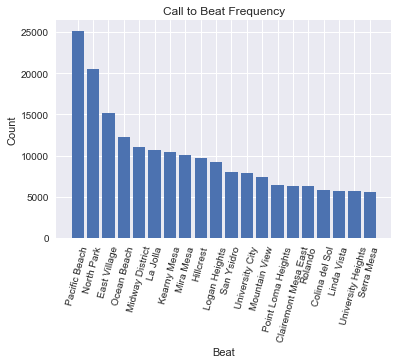

In [121]:

# Plotting bar graph in descending order
y_pos = np.arange(len(df_beat['beat']))
plt.bar(y_pos, df_beat['count'], align='center')
plt.xticks(y_pos, df_beat['Neighborhood'])
plt.ylabel('Count')
plt.xlabel('Beat')
plt.title('Call to Beat Frequency')
plt.xticks(rotation=75)
plt.show()

By referencing the beat number with our beat dictionary dataset, we can get more of a spacial reference. We'll do it for the first three beats that stick out. Maybe they're close in proximity, in a bad part of town, full of night-life, or all of the above.
After getting the neighborhood names of the beats and using a little bit of local knowledge, we see that all of those neighborhoods have a predominant night-life.
We also know that East Village is in downtown San Diego, and let's just say that maybe not all the crime originates from the night-crawlers.

In [122]:

# Grabbing the top three frequent beats
high_calls = pd.to_numeric(df_beat['beat'][0:3], errors='coerce')

# Match with the beat dictionary
beat_dict.loc[beat_dict['Beat'].isin(high_calls)]

Beat   Neighborhood
7    122  Pacific Beach
59   521   East Village
97   813     North Park

While seeing the count is nice, we can be more thorough. How does the time of the day change the amount of calls SDPD receives and are there differences in location with respect to time?

SPDP has received more calls during the day than night, surprisingly.

In [123]:

df_binCount = df['datetime'].value_counts()
df_binCount = pd.DataFrame({'Time':df_binCount.index, 'Count':df_binCount.values})
df_binCount = df_binCount[['Time','Count']]
df_binCount

Time   Count
0    DAY  238161
1  NIGHT  215508

We can now graph the change in crime from daytime to night-time with respect to beat. This will give us a rough picture of the overall trend for crime over the course of a day.
From the plot, we can see that only few beats move drastically (up or down) when heading towards night-time.

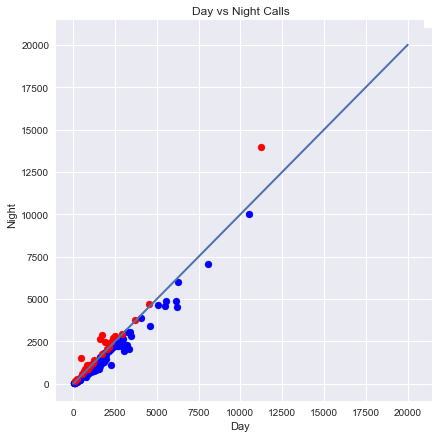

In [124]:
# Group by beat and time of day to get the counts
df_beat_bin = df.groupby(['beat','datetime']).size().reset_index(name='Count')
df_beat_bin.head(n=5)

#Long to Wide format
df_beat_long = df_beat_bin.pivot(index='beat', columns='datetime',values='Count')
df_beat_long['Beat']= df_beat_long.index
df_beat_long.reset_index(level=0, inplace=True)

sns.set_style("darkgrid")
x1 = df_beat_long[df_beat_long['DAY'] - df_beat_long['NIGHT'] > 0]['DAY']
y1 = df_beat_long[df_beat_long['DAY'] - df_beat_long['NIGHT'] > 0]['NIGHT']
x2 = df_beat_long[df_beat_long['DAY'] - df_beat_long['NIGHT'] < 0]['DAY']
y2 = df_beat_long[df_beat_long['DAY'] - df_beat_long['NIGHT'] < 0]['NIGHT']                                                                            

ax = sns.JointGrid(x1, y1, space=0, size=6, ratio=50)
ax.plot_joint(plt.scatter, color='b')
plt.scatter(x2,y2, color='r')
plt.plot([0,20000],[0,20000],linewidth=2)
x_label = 'Day'
y_label = 'Night'
plt.title('Day vs Night Calls', y=1.02)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

We can try to sort the biggest movers by calculating the percent change of the call frequency per beat.

In [129]:
# Group values and calculate percent change
dfh = df_beat_bin.groupby('beat')['Count'].pct_change()
df_beat_bin['Percent-Change'] = dfh
df_beat_bin.loc[df_beat_bin['datetime'] == 'NIGHT'].head()

beat datetime  Count  Percent-Change
1   111    NIGHT   2820       -0.190121
3   112    NIGHT    262       -0.286104
5   113    NIGHT   1219       -0.285044
7   114    NIGHT   2327       -0.179478
9   115    NIGHT   3865       -0.041419

Below, we see that on average crime reduces at night.  A few outliers have higher crime at night however.  All but one beat has less than 1 percent of change from day to night.

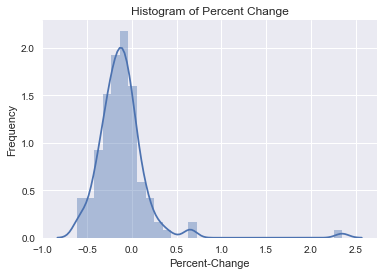

In [126]:
df_pctchng = df_beat_bin.dropna()

plt.ylabel('Frequency')
plt.title('Histogram of Percent Change')
ax = sns.distplot(df_pctchng['Percent-Change'])

# Data Visualisation: Perform KDE Modelling

In [19]:
from weighted_kde import gaussian_kde

The purpose of this step is to go from a discrete representation of crime (x, y points on a graph) to a continuous representation of crime. We can do so with a kernel density estimation. A kernel density estimation (KDE) is a statistical method to estimate the probability density function of a random variable. Scikit-learn and scikit-stats have pre-defined KDE methods. 

The code below sets up bounds for the KDE calculations so that we can optimize runtime, simplify calculations, and minimize useless calculations (for example, KDE calculations for ocean areas). These bounds were chosen so that the area was the largest square possible within the SDPD jurisdiction. SDPD jurisdiction is irregularly shaped, and including areas outside of the jurisdiction (where we lack data) would inaccurately represent crime in that area. Thus, we decided to run KDE on not the entire jurisdiction. 

In [20]:
SAN = x_range, y_range = (((np.mean(df_total['x']) - 10000),(np.mean(df_total['x']) + 10000)),((np.mean(df_total['y']) - 10000),(np.mean(df_total['y']) + 10000)))

plot_width = int(750)
plot_height = int(plot_width//1.2)

x_mean = np.mean(df_total['x'])
y_mean = np.mean(df_total['y'])
x_std = np.std(df_total['x'])
y_std = np.std(df_total['y'])

xmin = x_mean - x_std*1.9
xmax = x_mean + x_std*2
ymin = y_mean - y_std*1
ymax = y_mean + y_std*1


This code wrangles the data into KDE workable format, and runs several KDE’s: one for daytime crime, one for nighttime crime, and one for total crime.

In [21]:
xx, yy = np.mgrid[xmin:xmax:100, ymin:ymax:100]
positions = np.vstack([xx.ravel(), yy.ravel()])

dx = np.abs(xx[0,0] - xx[1,0])
dy = np.abs(yy[0,0] - yy[0,1])

total_values = np.vstack([df_total['x'], df_total['y']])
day_values = np.vstack([df_day['x'], df_day['y']])
night_values = np.vstack([df_night['x'], df_night['y']])

total_kernel = stats.gaussian_kde(total_values)
day_kernel = stats.gaussian_kde(day_values)
night_kernel = stats.gaussian_kde(night_values)

In [22]:
%%time
k_total = total_kernel(positions)
k_day = day_kernel(positions)
k_night = night_kernel(positions)


Wall time: 36min 3s


The function below defines the base plot for bokeh that we will be using.  It is re-used every time we plot maps with bokeh.

In [23]:
def base_plot(tools='pan,wheel_zoom,box_zoom,reset,save',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p
    


## Plot the Raw Crime Points
To visualize the geographic aspect of our crime data, we'll start with a scatter plot of the greater San Diego region.  The green points represent crime that took place during the daytime hours and the red points took place at night.  Larger points represent violent offenses.

In [24]:
%%time

p = base_plot()
p.add_tile(STAMEN_TERRAIN)
p.circle(x=df_total['x'], y=df_total['y'], alpha=0.05, color=['green' if x == 'DAY' else 'red' for x in df_total['datetime']], size=[5 if x == 1 else 2 for x in df_total['Violent']], **dict(line_color=None))

save(p, filename='html/crime_scatter.html')

Wall time: 2.78 s


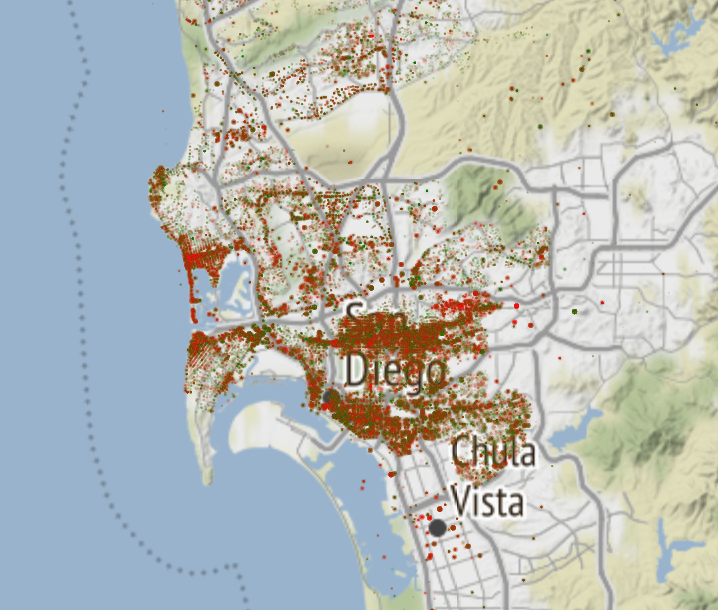

In [25]:
display(Image(filename='figures\crime_scatter.png', embed=True))

This plot gives us a good idea of where crime is concentrated. Notice there are no points on the island of Coronado, they have their own police department and are not under the jurisdiction of SDPD. Next we will separate day/night crime and use KDE to show areas that have high probability of crime during each timeframe, as well as look at if there are any changes in hotspots between day and night. 


## Plot the Crime KDE

The scatter plot looks great and highlights much of the structure of crime in San Diego, but to continue in our analysis we want a smooth function that models the crime at all locations in a given area.  For this, we will use a two dimensional kernel desnity estimate (KDE).  We will create three KDEs, one for morning, one for night, and one for crime at all times.  

In [26]:
# Plotting Parameters
alpha_scale = 150
color_scale = 250

### Crime Distribution (Day)
Below we plot the KDE for daytime crime.

In [27]:
%%time

kscale = (k_day)/np.max(k_total) * color_scale
colors = ["#%02x%02x%02x" % (int(r), int(0.1*g), int(0.1*g)) for r, g in zip(np.floor(kscale), np.floor(kscale))]


pday = base_plot()
pday.add_tile(STAMEN_TERRAIN)
pday.quad(left=positions[0,:]-(dx/2), right=positions[0,:]+(dx/2), top=positions[1,:]+(dy/2), bottom=positions[1,:]-(dy/2),color=colors, alpha=kscale/alpha_scale, **dict(line_color=None))

save(pday, filename='html/crime_day.html')

Wall time: 911 ms


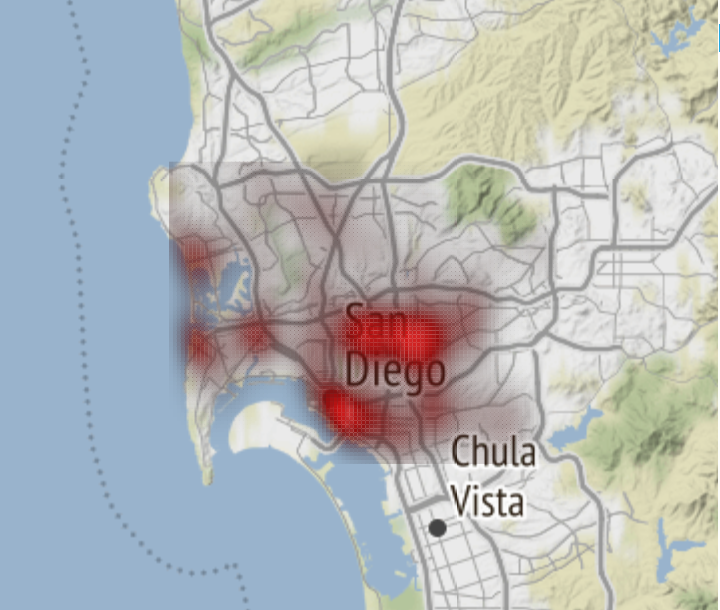

In [28]:
display(Image(filename='figures\crime_day.png', embed=True))

Crime during the day appears to be most concentrated in the Normal Heights/North Park area and downtown San Diego, with less intense hotspots in Pacific Beach (North part of the Bay), Ocean Beach (South part of the bay), and East Village (Southeast of the bay).

### Crime Distribution (Night)
Below is the night crime.

In [29]:
%%time

kscale = (k_night)/np.max(k_total) * color_scale
colors = ["#%02x%02x%02x" % (int(r), int(0.1*g), int(0.1*g)) for r, g in zip(np.floor(kscale), np.floor(kscale))]


pnight = base_plot()
pnight.add_tile(STAMEN_TERRAIN)
pnight.quad(left=positions[0,:]-(dx/2), right=positions[0,:]+(dx/2), top=positions[1,:]+(dy/2), bottom=positions[1,:]-(dy/2),color=colors, alpha=kscale/alpha_scale, **dict(line_color=None))

save(pnight, filename='html/crime_night.html')

Wall time: 872 ms


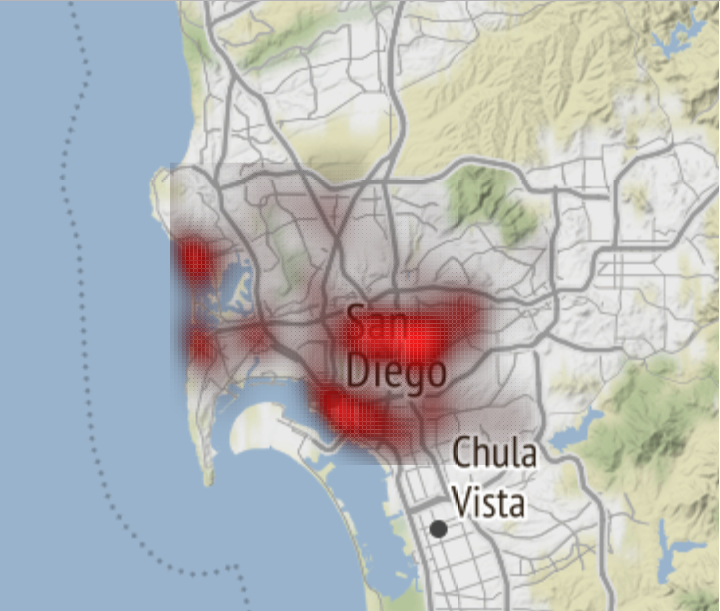

In [30]:
display(Image(filename='figures\crime_night.png', embed=True))

The crime hotspots during the night are nearly identical to the daytime hotspots. The only difference is that crime appears more concentrated in these areas (indicated by deeper red).


### Temporal Difference in Crime Distribution
Below we plot the diffrence between the day and night crime.  These areas have increased activity at night.  One could create a complimentary plot that illustrates locations where crime is more active at day, or even combine these two plots.  Our anaylsis showed that no areas showed substantially more crime in the day so such a plot is omitted.  

In [31]:
%%time
kdiff = k_night-k_day
from bokeh.tile_providers import STAMEN_TERRAIN

kscale = (kdiff)/np.max(k_total) * color_scale *5
colors = ["#%02x%02x%02x" % (int(r), int(0.1*g), int(0.1*g)) for r, g in zip(np.floor(kscale), np.floor(kscale))]


pdiff = base_plot()
pdiff.add_tile(STAMEN_TERRAIN)
pdiff.quad(left=positions[0,:]-(dx/2), right=positions[0,:]+(dx/2), top=positions[1,:]+(dy/2), bottom=positions[1,:]-(dy/2),color=colors, alpha=kscale/alpha_scale, **dict(line_color=None))

save(pdiff, filename='html/crime_diff.html')

Wall time: 888 ms


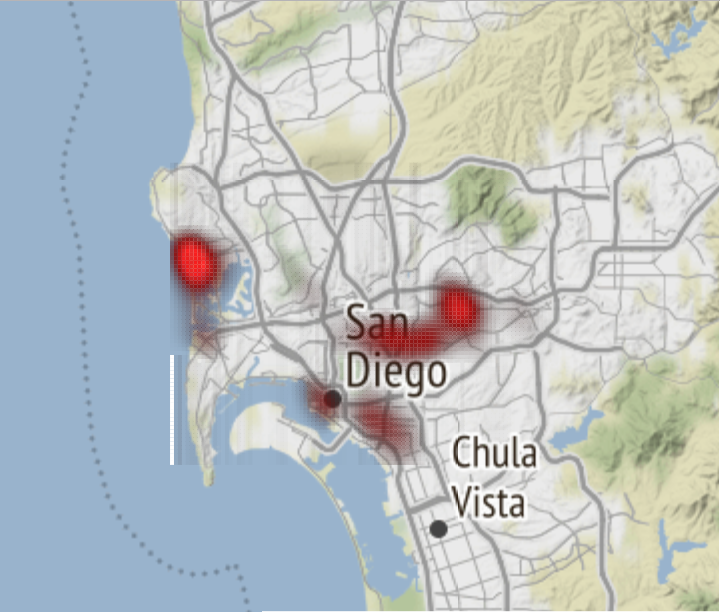

In [32]:
display(Image(filename='figures\crime_diff.png', embed=True))

As you can see, the largest area of change between day and night crime happens in Pacific Beach, an area known for nightlife. There’s also an increase around downtown San Diego, which, while busy during all times of the day, is known for nightlife as well. Finally, the crime hotspot by the “San” on the map corresponds to Normal Heights/North Park, another nightlife area. So applying our real-world knowledge, these plots appear to make sense. Since the hotspots are very similar for nighttime and daytime (and due to project time constraints), we decided to go ahead with one version of optimization using total day/night data instead of separate optimizations for each timeframe. 


## Distributing Patrol Cars

In the following sections of this notebook, we will investigate how to optimally distrubute cars over the SDPD jurisdiction.  In order to quantitatively asses the quality of a distribution, we will define a cost function.  This cost function is based on the euclidean distance between cars and crime points, a metric we wish to minimize.


#### The Cost Function

Where $i$ indexs the locations on the $x,y$ grid $P=p_1, p_2, ... p_N$, $j$ indexes the car locations $C = c_1, c_2, ... c_M$, $D(x,y)$ is the euclidean distance between two points, and $W_i$ is the crime probability at point $p_i$ the $MindDistCost$ is defined as:

$$ MinDistCost =  \sum_{i = 1}^{N} \underset{j}{argmax} [ D(p_i,c_j)W_i] $$

This $MindDistCost$ function sums over all of the KDE points and takes the distance to the closest police car weighted by the crime. We use this function to model the response time of the closest car.

We also care to incorporate the response time for the next $K$ closest cars.  

$$ KDistCost =  \sum_{i = 1}^{N}  \underset{Z \in C, |Z| = K}{argmax} \sum_{j \in Z} D(p_i,c_j)W_i $$

Finally, our function $WeightedCost$ is the weighted average of these two cost functions.  This allows the optimization algorithm to consider the initial response time and the nearby police presence.  

In [33]:
def KDECostClosest(crime_locs, crime_weights, car_locs):
    """
    Calculates the distance from each crime point to the nearest police car and returns the sum
    """
    dist = pairwise_distances(crime_locs,car_locs)
    min_dist = np.amin(dist, axis=1)
    return np.sum(min_dist*crime_weights)
    


def KDECostClosestAll(crime_locs, crime_weights, car_locs):
    """
    Calculates the distance from each crime point to the nearest police car and returns the sum
    """
    n_closest = 5
    dist = pairwise_distances(crime_locs,car_locs)
    dist.sort(axis=1)
    dist = dist[:,:n_closest]
    mean_dist = np.mean(dist, axis=1)
    return np.sum(mean_dist*crime_weights)
    

def KDECostWeighted(crime_locs, crime_weights, car_locs):
    return 0.6*KDECostClosest(crime_locs, crime_weights, car_locs) + 0.4*KDECostClosestAll(crime_locs, crime_weights, car_locs)


### Initalize the distribution of cars
Here we initialize `n_cars` cars by sampling randomly from all of the crime points in our region of interest.  When compared to other methods of distribution, we refer to this method as the crime sampling distribution method.  This non-uniform and non-gaussian distribution of cars leads to better initial conditions for the optimizing algorithm.

In [34]:
# Initialize Car Locations
n_cars = 50

## Get the set of all crime in our region of analysis
df_potential_locs = df_total[['x', 'y']].loc[(df_total['x'] > xmin) & (df_total['x'] < xmax) & (df_total['y'] > ymin) & (df_total['y'] < ymax)]
car_locs =  np.array(df_potential_locs.sample(n=n_cars))

print('Initially, the total cost is %.5f' % KDECostWeighted(positions.T, k_total, car_locs))

Initially, the total cost is 0.15667


### Plot the Distribution of Cars Initially

Here’s our plot of our initial, random, unoptimized distribution of cars. There are a lot of cars that are fairly close to each other, and we believe that those clusters of cars could be a waste of resources. We will now try to improve this model.


In [35]:
%%time
from bokeh.tile_providers import STAMEN_TERRAIN

kscale = (k_total)/np.max(k_total) * color_scale
colors = ["#%02x%02x%02x" % (int(r), int(0.1*g), int(0.1*g)) for r, g in zip(np.floor(kscale), np.floor(kscale))]


p3 = base_plot()
p3.add_tile(STAMEN_TERRAIN)
p3.quad(left=positions[0,:]-(dx/2), right=positions[0,:]+(dx/2), top=positions[1,:]+(dy/2), bottom=positions[1,:]-(dy/2),color=colors, alpha=kscale/alpha_scale, **dict(line_color=None))
p3.circle(x=car_locs[:,0], y=car_locs[:,1], **dict(line_color=None, fill_color='blue', size=10))

save(p3, filename='html/init_dist.html')

Wall time: 916 ms


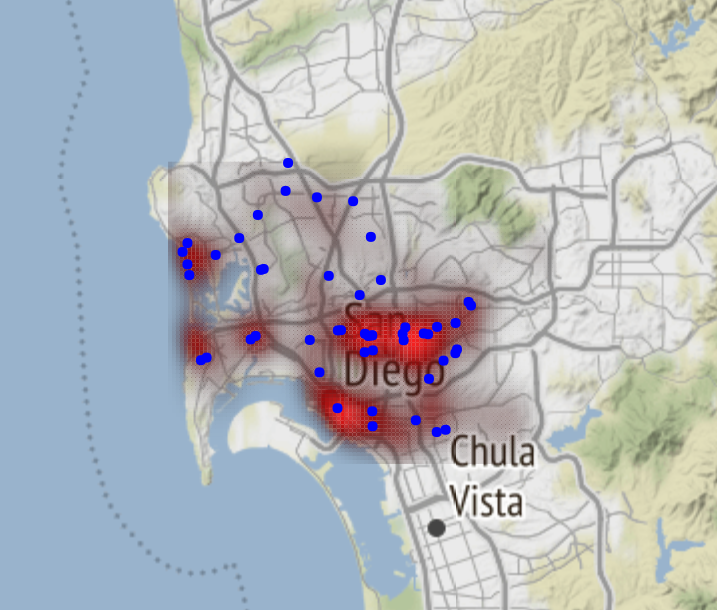

In [36]:
display(Image(filename='figures\init_dist.png', embed=True))

### Baseline Performance of Distribution Methods

Below, we seek to understand how naive distribution methods perform using the above cost functions.  

We generate 1000 random dsitributions for three different distribution methods (Gaussian, Uniform, and Crime Sampling).  

The *Uniform Distribution* samples over the space defined by the KDE.  The *Gaussian Distribution* is centered at the centroid of all crime points.  The *Crime Sampling Distribution* samples randomly from all crime points.

We will also calculate a slightly coarser KDE to reduce running times.

In [55]:
xx, yy = np.mgrid[xmin:xmax:500, ymin:ymax:500]
positions = np.vstack([xx.ravel(), yy.ravel()])

dx = np.abs(xx[0,0] - xx[1,0])
dy = np.abs(yy[0,0] - yy[0,1])


process_kernel = stats.gaussian_kde(total_values)

k_process = process_kernel(positions)



In [56]:
ntrials = 1000
u_dist = np.zeros(ntrials)
g_dist = np.zeros(ntrials)
smart_dist = np.zeros(ntrials)


for i in range(ntrials):
    
    # Get distribution of initial costs (Uniform Distribution)
    rows = np.random.choice(np.shape(positions)[1], n_cars)
    car_locs = positions.T[rows,:]
    u_dist[i] = KDECostWeighted(positions.T, k_process, car_locs)
    
    # Get distribution of initial costs (Gaussian Distribution)
    x = np.random.randn(n_cars, 1)*(xmax-xmin)*0.2 + x_mean
    y = np.random.randn(n_cars, 1)*(ymax-ymin)*0.2 + y_mean
    car_locs = np.hstack([x,y])
    g_dist[i] = KDECostWeighted(positions.T, k_process, car_locs)
    
    # Get distribution of initial costs (Crime Sampling Distribution)
    car_locs =  np.array(df_potential_locs.sample(n=n_cars))
    smart_dist[i] = KDECostWeighted(positions.T, k_process, car_locs)



mean_cost_uni = np.mean(u_dist)
g_mean_cost = np.mean(g_dist)
smart_mean_cost = np.mean(smart_dist)


We see below that the Crime Sampling distribution is the best of the three and the Gaussian and Uniform methods perform equally poorly.  In the following sections, we aim to create an optimizing algorithm that improves the distribution of police cars.

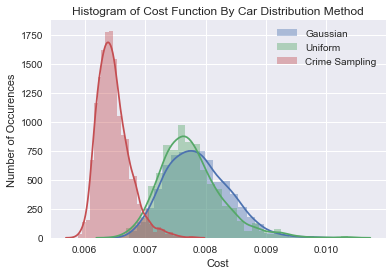

In [57]:
sns.distplot(g_dist)
sns.distplot(u_dist)
sns.distplot(smart_dist)
plt.legend(['Gaussian', 'Uniform', 'Crime Sampling'])
plt.title('Histogram of Cost Function By Car Distribution Method')
plt.xlabel('Cost')
plt.ylabel('Number of Occurences')

## Optimization

### Intializing The Optimization Aglorithm
As seen above, there are several ways to initialize the distribution of police cars throughout the city.  For this analysis, we will be initializing the cars by sampling from the actual crime locations. This will give us a distribution of cars that mimics the distribution of crime.  It is worth noting that this may not be the optimal method of initialization for the algorithm.  Although simulated annealing works to avoid local minima, it is possible that the 'smart' initial distribution has negative consequence for the optimization process.

The initialization function below takes a threshold and a kde matrix.  It then randomly samples sets of `n_cars` from all crime locations.  If that set of cars has a cost below a threshold parameter, then it is accepted as an initial state. 

In [77]:
def SelectInitDist(thresh, kde):
    while True:
        potential_init =  np.array(df_potential_locs.sample(n=n_cars))
        if KDECostWeighted(positions.T, kde, potential_init) < thresh:
            break
    return potential_init
        

### The Optimization Process

In the cell below, a function is defined that performs a single optimization trial.

The method is based off of simulated annealing.  A temperature is defined that controls the lilihood that the algorithm will travel to a less favorable state.  This temperature is _anealled_ over the course of the optimization and the algorithm becomes more conservative until it accepts only favorable states.  This annealing process allows it travel out of local minima in an attempt to find the global minima of the state space.

During each step in the optimzation trial, the cars are looped over in sequence.  A new position is proposed for each car and this position is accepted with the following probability: 

$$ a = \frac{e^{\frac{-C(X`)}{T}}}{e^{\frac{-C(X)}{T}}} $$

If the position is accepted, the location of the car is modified, otherwise it is kept the same before moving onto the next car.  After modifying all cars, the current cost and state of the system is recorded before moving onto the next iteration through the current trial.  After all training steps are complete, the best cost and corresponding state are returned.

In [97]:
def OptimizationTrial(kde):
    
    nsteps = 200
    trial_best_cost = 10000
    trial_best_state = None
    
    T = 0.0002
    annealing_rate = 0.9995
    step_size = (xmax-xmin)/10

    costs = np.zeros(nsteps)

    trial_car_locs =  SelectInitDist(smart_mean_cost*0.93, kde)

    for step_num in range(nsteps):

        T = T * annealing_rate
        step_size = step_size * annealing_rate
        for car_num in range(n_cars):

            # Get stats on current state
            curr_cost = KDECostWeighted(positions.T, kde, trial_car_locs)

            # Propose new state for car
            new_state = np.copy(trial_car_locs)
            new_state[car_num,:] += (np.random.rand(2)-0.5)*step_size
            new_cost = KDECostWeighted(positions.T, kde, new_state)

            # If state is better accept | If not better, accept with certain probability
            if np.random.rand() < np.exp(-1*new_cost/T)/np.exp(-1*curr_cost/T):
                trial_car_locs = new_state


        # Determine total system cost.
        costs[step_num]= KDECostWeighted(positions.T, kde, trial_car_locs)
        if costs[step_num] < trial_best_cost:
            trial_best_cost = costs[step_num]
            trial_best_state = trial_car_locs
    
    return trial_best_cost, trial_best_state
        

Now that the optimization algorithm is defined, run the algorithm `ntrials` times, each with its own initial distribution.


In [ ]:
%%time
ntrials = 60
min_cost = 10000
min_state = None

simulation_costs = []
simulation_states = []


for trial_num in range(ntrials):
    print(trial_num)
    cost, state = OptimizationTrial(k_process)
    simulation_costs.append(cost)
    simulation_states.append(state)
    
    if cost < min_cost:
        min_cost = cost
        min_state = state
    
    


The output of the above cell was cleared for the sake of readability

### Does our optimization algorithm reduce the cost function?

The figure below shows that our optimization algorithm provides the optimal distribution of police cars. Even compared to the crime sampling distribution, the optimization method is able to reduce the cost further.  

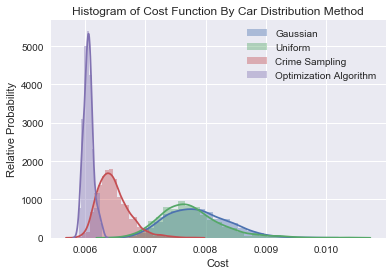

In [99]:
dist_options = dict(bins=None, hist=True, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=True, axlabel=None, label=None, ax=None)
sns.distplot(g_dist, **dist_options)
sns.distplot(u_dist, **dist_options)
sns.distplot(smart_dist, **dist_options)
sns.distplot(simulation_costs, **dist_options)
plt.legend(['Gaussian', 'Uniform', 'Crime Sampling', 'Optimization Algorithm'])
plt.title('Histogram of Cost Function By Car Distribution Method')
plt.xlabel('Cost')
plt.ylabel('Relative Probability')


### What does our distribution of police cars look like after optimization?
As is evident below, the post-optimization distribution fits the data well.  It has a higher density of cars in area with more crime and has fewer patrol cars in areas that are crime-free.


In [103]:
%%time
# Plot the final distribution of police cars

kscale = (k_process)/np.max(k_process) * color_scale
colors = ["#%02x%02x%02x" % (int(r), int(0.1*g), int(0.1*g)) for r, g in zip(np.floor(kscale), np.floor(kscale))]

p4 = base_plot()
p4.add_tile(STAMEN_TERRAIN)
p4.quad(left=positions[0,:]-(dx/2), right=positions[0,:]+(dx/2), top=positions[1,:]+(dy/2), bottom=positions[1,:]-(dy/2),color=colors, alpha=kscale/alpha_scale, **dict(line_color=None))
p4.circle(x=min_state[:,0], y=min_state[:,1], **dict(line_color=None, fill_color='blue', size=10))

save(p4, filename='html/opt_dist.html')

Wall time: 158 ms


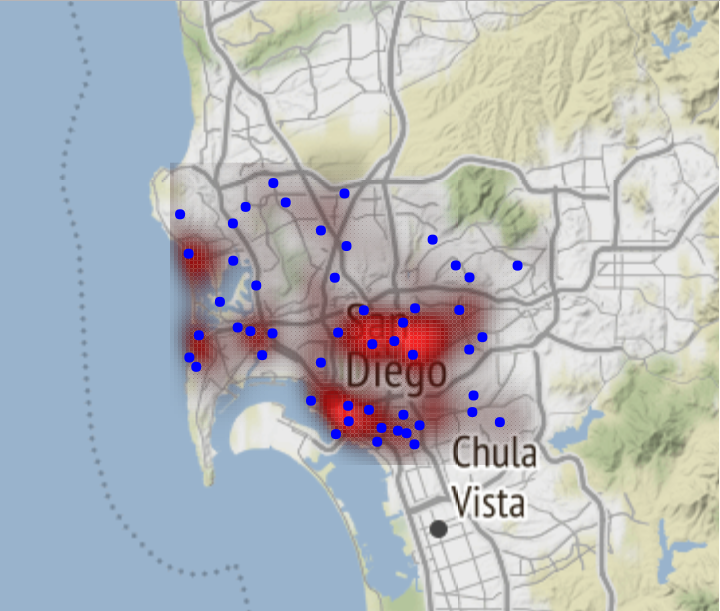

In [104]:
display(Image(filename='figures\opt_dist.png', embed=True))

## Conclusion and Discussion



### Overview
We set out to identify any structures that might exist in the spatial and temporal distribution of crime throughout the greater  San Diego area.  Using these temproal and spatial featrures, we hoped to design an algorithm for the optimal placement of patrol cars throughout the city.  We benchamarked this model against naive and traditional techniques and observed that it performed better in all cases. 


### Temporal Distribution of Crime
We found that the overall distribution of crime changes slightly throughout the day. Most regions having less crime at night, but some regions such as Pacific Beach have substantially more crime at night.  After seeing these results we decided to perform the optimization procedure on all of the data instead of temporally separated data.


### Spatial Distribution of Crime
The spatial distribution of crime had much more pronounced features.  We found that there are 5 primary crime hotspots in the San Diego area (Pacific Beach, Ocean Beach, Midway District, North Park, and the East Village).  

 


### Optimal Patrol Car Placement

Because the distribution of crime is not uniform over San Diego, it is reasonable to think the the distribution of police cars should not be either.  The most naive method is to consider the centroid of all crime and perform a gaussian distribution of cars with this centroid as a mean.  A more advanced method samples from the crime distribution in order to get a matching car distribution. We observed that this crime sampling method was more effective than the uniform and gaussian methods, but we wanted to optimize the distribution further.  

We implemented a simulated annealing optimization algorithm that sought to optimize our cost function defined above.  This cost function used on the eucliean distance (as the crow flies) instead of travel distance or even estimated travel time.  This simulated annealing algorithm started with an intial distribution of cars sampled from the crime space.  This distribution of cars then underwent 100 optimization steps where cars were individually perturbed in pursuit of a more optimal distribution.  

We saw that the optimized crime sampling distribution was the best method for patrol car placement.  On average, it performed better than all other distribution methods.  The plot of the final distribution of patrol cars confirms our hypothesis that an uneven crime distribution warrants an uneven car distribution.

### Potential Improvements
The model created above does not describe real world conditions.  There are many improvements that could be made to better fit the real world thus better distribute patrol cars.  

##### Geographical Bounds
We chose geographical bounds that fit a large portion of the city of San Diego. The actual jurisdtication of the San Diego Police Department covers a complex area with panhandles and discontinuities.  In order to improve the model, we could could included all of the SDPD jurisdiction and limit our crime distribution analysis to areas within these bounds.

##### Unrealistic Cost Function
Our cost function does not account for the fact that cars travel on roads and at varying speeds.  To improve our model, we could have used travel distance and travel time.

##### Unrealistic Car Locations
Our model did not limit the car locations to streets and highways.  In our model cars could wind up in Mission Bay or the San Diego harbor.  They could even travel outside the KDE location.  



### Further Questions

There are many questions still outstanding in this work.  Does the spatial distribution of crime change on a larger temporal scale such as days of the week, months, or year?  Do different areas have different temporal structures or idosyncracies, or do all areas move as one?  How do these results change if we use a cost function that better mimics response time such as travel distance?  In reality not all crime is of equal importance; how does the model change if we weight violent crimes higher than other crimes?  


